In [6]:
import numpy as np
import pickle
from scipy.stats import binom
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(0)

# Toy Problem : Binomial Data

## 1. Data samples and analysis

As toy problem, we study the medGAN algorithm on a single variable following a binomial distribution $B(n, p)$.

We generate $N$ samples that will be our database $X$ with shape $(N, 1)$.

Here we choose the following parameters :

\begin{equation*}
N = 1000 \\
n = 10 \\
p = 0.3
\end{equation*}


In [132]:
n, p = 10, 0.3
size = 1000

dist = binom(n, p)
data = dist.rvs(size)

# Save data to data.matrix.
#pickle.dump(np.expand_dims(data, 1), open('../data/data_binomial.matrix', 'wb'), -1)

In [149]:
th_probabilities = np.apply_along_axis(lambda x: dist.pmf(x), 0, range(n))
th_frequencies = th_probabilities * size
emp_frequencies = np.bincount(data, minlength=n) 
emp_probabilities = emp_frequencies / size

Quick look at our generated database and the theoretical probabilities of binomial distribution.

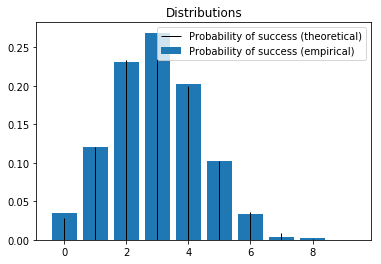

In [150]:
plt.bar(range(n), emp_probabilities, label='Probability of success (empirical)')
plt.vlines(range(n), 0, th_probabilities, colors='k', linestyles='-', lw=1,label='Probability of success (theoretical)')
plt.legend()
plt.title('Distributions')
plt.show()

## 2. Data generation using medGAN

We will now use medGAN to generate samples from our dataset and do a quick overview of the results.

We generate $N$ samples for our generated_data $X_g$.

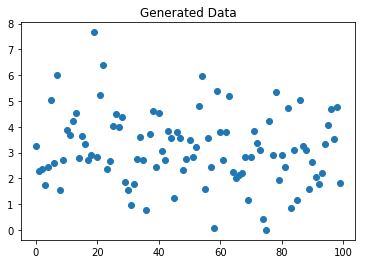

In [151]:
import matplotlib.pyplot as plt 

gen_data = np.load('../generated/synthetic_data_binomial.npy')
plt.plot(gen_data, 'o')
plt.title('Generated Data')
plt.show()

Obviously, data that is generated is not mapped exactly to integer values so rounded values need to be taken.

We can then compare to our original data.

For visualization purposes, we look at the first 100 points.

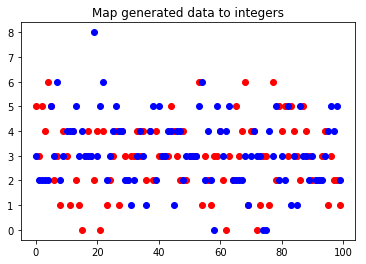

In [153]:
gen_data = np.squeeze(np.round(gen_data).astype(int))
gen_emp_probabilities = np.bincount(gen_data, minlength=n) / len(gen_data)

plt.plot(data[:100], 'ro')
plt.plot(gen_data[:100], 'bo')
plt.title('Map generated data to integers')
plt.show()

Even with rounding, it is hard to compare just by looking at a simple plot of the points.

Let us have a look at distributions and some other metrics.

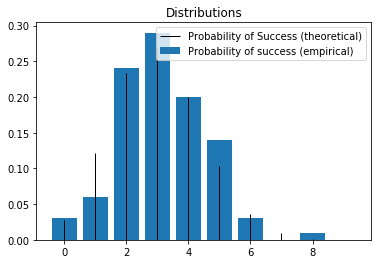

In [154]:
plt.bar(range(n), gen_emp_probabilities, label='Probability of success (empirical)')
plt.vlines(range(n), 0, th_probabilities, colors='k', linestyles='-', lw=1, label='Probability of Success (theoretical)')    
plt.legend()
plt.title('Distributions')
plt.show()

Generated data $X_g$ draw more 0s than expected and less 1s compared to the true distribution.

Generated data seems to follow a geometric distribution.

To further analyse those differences, let us look at a simple metrics.

In [155]:
pd.concat([pd.DataFrame(data).rename(columns={0:'data'}), pd.DataFrame(gen_data).rename(columns={0:'generated_data'})], axis = 1).describe()

,data,generated_data
count,1000.000000,100.000000
mean,2.952000,3.170000
std,1.428193,1.421729
min,0.000000,0.000000
25%,2.000000,2.000000
50%,3.000000,3.000000
75%,4.000000,4.000000
max,8.000000,8.000000


Mean is actually lower on the generated_data even the standard deviation seem to be approximately the same for both.

Note that GAN was only trained for 10 epochs and the autoencoder for 50.
Increasing the dimension of the autoencoder or the number of epochs of both GAN and autoencoder could provide better results.

Even though the code of medGAN is badly written from a programming point of view (for loops using useless temporary variable, default variables assigned twice, ...), it should work quite well on this simple toy problem

### Chi - squared test

Hypothesis : X and Y follow the same distribution.

For the chi squared test to be valid, expected frequencies need to be at least of 5.

Frequencies of the last categories are smaller than 5. 

We need to adjust our categories to be able to apply chi squared test. We can do this by pooling the last categories.

In [183]:
th_probabilities_modified = np.append(th_probabilities[:-3], np.sum(th_probabilities[-3:]))
emp_probabilities_modified = np.append(emp_probabilities[:-3], np.sum(emp_probabilities[-3:]))
gen_emp_probabilities_modified = np.append(gen_emp_probabilities[:-3], np.sum(gen_emp_probabilities[-3:]))

In [184]:
chi_squared = (emp_probabilities_modified - th_probabilities_modified)**2 / th_probabilities_modified
gen_chi_squared = (gen_emp_probabilities_modified - th_probabilities_modified)**2 / th_probabilities_modified

In [186]:
chi_squared_test = np.sum(chi_squared)
gen_chi_squared_test = np.sum(gen_chi_squared)
print(chi_squared_test)
print(gen_chi_squared_test)

0.0050313126213311745
0.047735741968594106


In [216]:
from scipy.stats import chisquare

# Chi-square test with 
# (number of categories after pooling)-(number of parameters estimated)-1
#  = 8 - 1 - 1 = 6 degrees of freedom
print(chisquare(emp_probabilities_modified, th_probabilities_modified, ddof = 6))
print(chisquare(gen_emp_probabilities_modified, th_probabilities_modified, ddof = 6))

Power_divergenceResult(statistic=0.0050313126213311745, pvalue=0.9434520771736926)
Power_divergenceResult(statistic=0.047735741968594106, pvalue=0.8270511609541289)


Both p-value are >0.5 so we can assess that they follow the null hypothesis.

## Network analysis

Now let us have a look at different metrics of the GAN block of our network.

In [217]:
temp = open('../models/model_binomial.log', 'r')

epoch = list()
d_loss = list()
g_loss = list()
accuracy = list()

for line in temp:
    line = line.strip()
    for element in line.split(','):
        tmp = element.split(':')
        if tmp[0] == 'Epoch':
            epoch.append(tmp[1])
        elif tmp[0] == ' d_loss':
            d_loss.append(tmp[1])
        elif tmp[0] == ' g_loss':
            g_loss.append(tmp[1])
        elif tmp[0] == ' accuracy':
            accuracy.append(tmp[1])

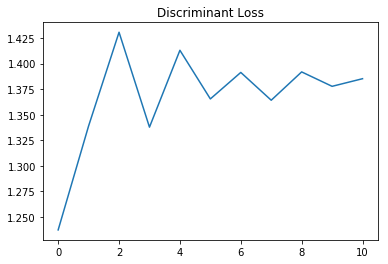

In [218]:
plt.plot(d_loss)
plt.title('Discriminant Loss')
plt.show()

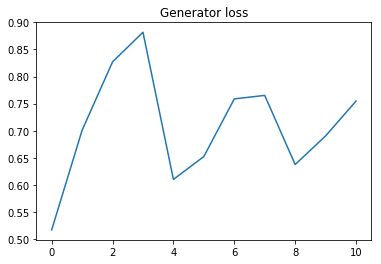

In [219]:
plt.plot(g_loss)
plt.title('Generator loss')
plt.show()

Note that the discriminant is trained five times more for each time we train the generator.

We could perform more epochs during the training phase in order to see when the networks stops to learn and losses to converge to some values.

A further analysis could be done on this part.

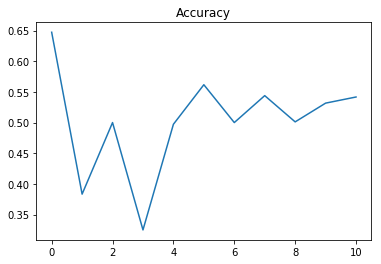

In [220]:
plt.plot(accuracy)
plt.title('Accuracy')
plt.show()

When looking to the accuracy, there seems to be a tradeoff between the discriminant and the generator which is reassuring. 

It means that the discriminator is fooled as much times as the generator produces a bad example. 

As for losses, we should perform more epochs to see a trend for convergence.